## Develop an n-Gram CNN Model for Sentiment Analysis.

We have seen in previous code how to build models for text classification, with most recently the use of the embedding layer  and one dimensional convolutional neural network. 

We can expand this knowledge by using multiple parallel convolutional neural networks that read the source document using different kernel sizes.

This in effect creates a multichannel convolutional neural network for the text that reads text with different n-gram sizes (groups of words). 

So in this script we'll develop a multichannel convolutional nural network for sentiment prediction on text moview review data. The focus will shift from the data cleaning as we've already written functions to preprocess the data. So we'll just import those functions and work with them.

#### 1. The Dataset.

The data is the movie review polarity dataset hosted in this link: http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
        
    After unzipping, this file contains 2000 positive and negative reviews of movies split into 1000 for each class. So we'll use 900 from each class for training and 100 for testing, bringing our total data size for training to 1800.

#### 2. Data Preparation.

In [1]:
# import our functions and other modules
from text_prep import *
from save_processed import *
from numpy import array

Using TensorFlow backend.


In [2]:
# Other modules
import string, re
from os import listdir
from nltk.corpus import stopwords
from pickle import dump

In [3]:
# Cleaning functions
# Use load_doc()
# Clean a new document
def clean_docs(doc):
    """
    Parameters:
    doc: a loaded document

    Return
    tokens: a cleaned document"""
    # Split into tokens by white space.
    tokens = doc.split()
    # Prepare regex for character filtering.
    re_punctuation = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word.
    tokens = [re_punctuation.sub('', w) for w in tokens]
    # remove remaining non-alphabetic tokens.
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stopwords.
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]
    # Filter out short tokens.
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

def process_docs_full1(directory, is_train):
    """
    Parameters:
    directory: a directory to traverse
    vocab: set of vocabularies

    Return:
    lines: cleaned and straightened documents from a directory"""
    document = list()
    # walkthrough all files in the folder
    for filename in os.listdir(directory):
        # Skip files that do not have the right extension
        # if not filename.endswith('.txt'):
        #     next
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # Load and clean the doc
        doc = load_doc(path)
        # Clean doc
        tokens = clean_docs(doc)
        # Add to list
        document.append(tokens)
    return document

# Load, clean and combine a dataset
def load_clean_dataset(is_train):
    """
    params:
    vocab: train vocabulary
    is_train: switch to select training and testing sets. Set to True for train, False for test.
    
    return:
    docs: a combined documents dataset
    labels: all labels in the set"""
    # load documents
    neg = process_docs_full1('Data/txt_sentoken/neg', is_train)
    pos = process_docs_full1('Data/txt_sentoken/pos', is_train)
    docs = neg + pos
    # prepare labels
    labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
    return docs, labels

# Save a dataset to file
def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [4]:
# Load and clean all reviews
train_docs, y_train = load_clean_dataset(True)
test_docs, y_test = load_clean_dataset(False)
# Save training datasets
save_dataset([train_docs, y_train], 'Data/train.pkl')
save_dataset([test_docs, y_test], 'Data/test.pkl')

Saved: Data/train.pkl
Saved: Data/test.pkl


We have cleaned our data, split into train and test sets and serialized it so we can always use it for other tasks.

#### 3. Develop Multichannel Model.

We'll do 3 things in this section:
    1. Encode Data
    2. Define Model
    3. Complete Example.

##### Encode Data;

In [13]:
# module
from pickle import load
from keras.preprocessing.sequence import pad_sequences

In [10]:
# Load the cleaned dataset using a function
def load_dataset(filename):
    return load(open(filename, 'rb'))

# Calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

# Integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
    """
    params:
    tokenizer: a tokenizer class created from the function create_tokenizer
    max_length: a maximum length all documents must have, gotten from the size of the largest document
    docs: a combined review set of positive and negative.
    
    returns:
    padded: an integer encoded, padded sequence of documents.
    """
    # integer encode 
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

We now need to fit a keras tokenizer on the training dataset. We will use this tokenizer to both define the vocabulary for the Embedding layer and encode the review documents as integers.

Access the tokenizer instance using the create_tokenizer() function already imported.

In [11]:
# load our data
trainLines, trainLabels = load_dataset('Data/train.pkl')
len(trainLines), len(trainLabels)

# Create tokenizer
tokenizer = create_tokenizer(trainLines)

# Calculate maximum document length
length = max_length(trainLines)
print('Maximum document length: %d' % length)

# Calculate vocabulary size
vocab_size = len(tokenizer.word_index)+1
print('Vocabulary size: %d'% vocab_size)

Maximum document length: 1380
Vocabulary size: 44277


In [14]:
# Encode data
X_train = encode_docs(tokenizer, length, trainLines)
print(X_train.shape)

(1800, 1380)


##### Define Model;

In [15]:
# Import modules
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding, concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [20]:
# Define the model
def multi_cnn_embed1(length, vocab_size):
    # Channel 1
    input1 = Input(shape=(length,))
    embed1 = Embedding(vocab_size, 100)(input1)
    convd1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embed1)
    drops1 = Dropout(0.5)(convd1)
    poold1 = MaxPooling1D(pool_size=2)(drops1)
    flatd1 = Flatten()(poold1)
    
    # Channel 2
    input2 = Input(shape=(length,))
    embed2 = Embedding(vocab_size, 100)(input2)
    convd2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embed2)
    drops2 = Dropout(0.5)(convd2)
    poold2 = MaxPooling1D(pool_size=2)(drops2)
    flatd2 = Flatten()(poold2)
    
    # Channel 3
    input3 = Input(shape=(length,))
    embed3 = Embedding(vocab_size, 100)(input3)
    convd3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embed3)
    drops3 = Dropout(0.5)(convd3)
    poold3 = MaxPooling1D(pool_size=2)(drops3)
    flatd3 = Flatten()(poold3)
    
    # Merge
    merged = concatenate([flatd1, flatd2, flatd3])
    
    # Interpretation
    dense1 = Dense(10, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs = [input1, input2, input3], outputs = output) #
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Summarize model
    model.summary()
    return model

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1380)         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1380)         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 1380)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1380, 100)    4427700     input_5[0][0]                    
____________________________________________________________________________________________

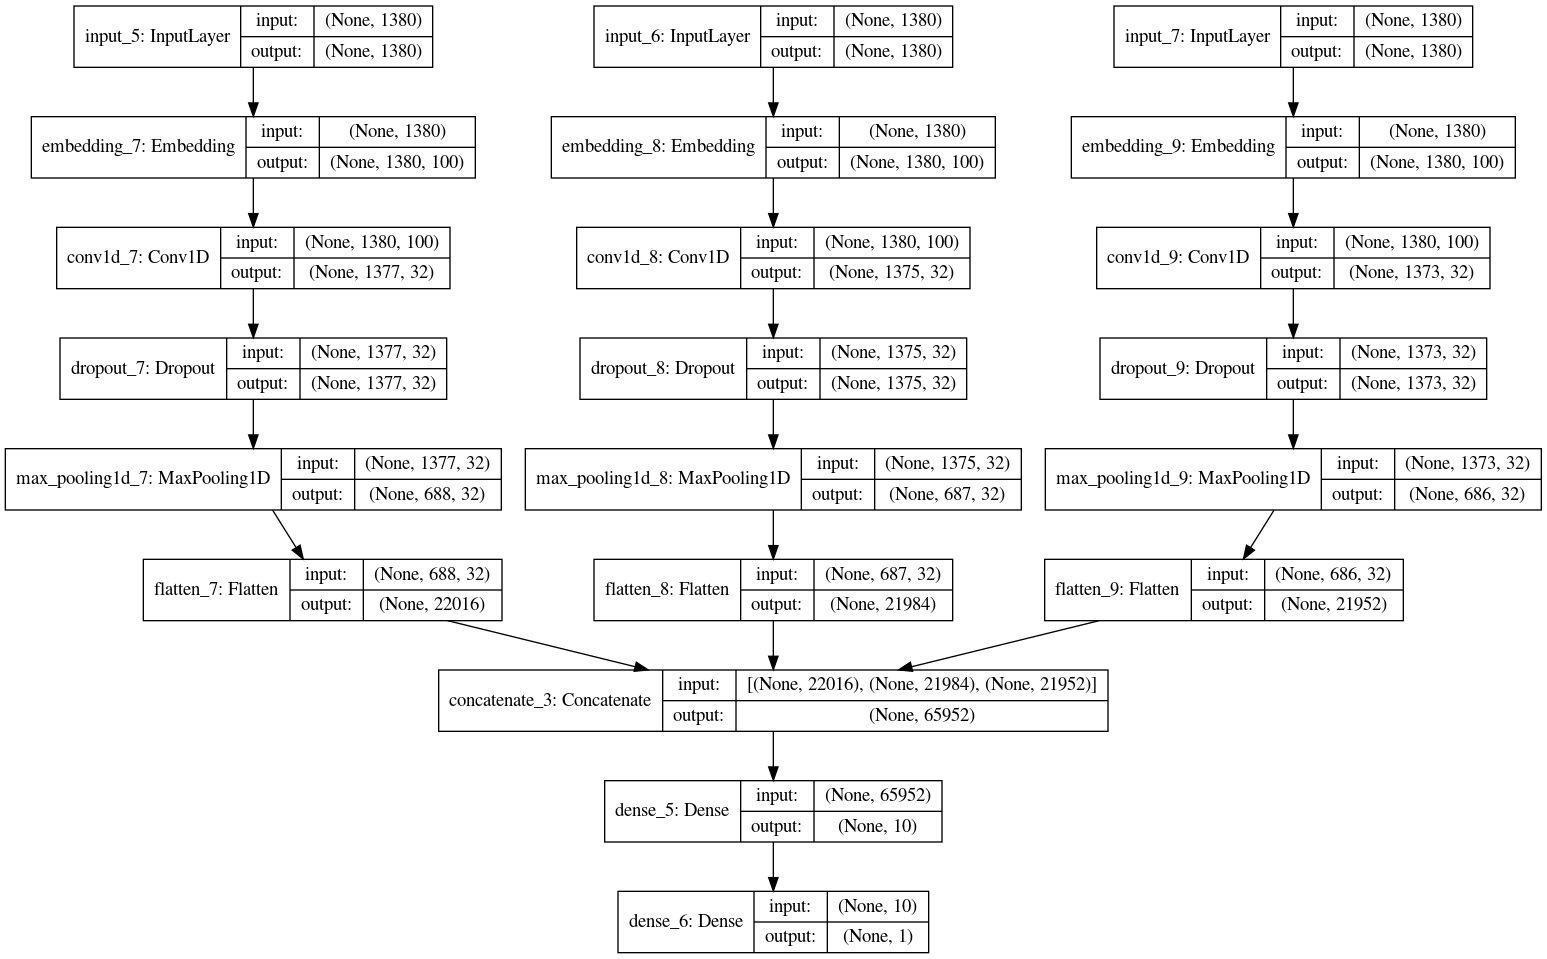

In [21]:
model = multi_cnn_embed1(length, vocab_size)
plot_model(model, show_shapes=True, to_file='Model_Imgaes/multi_cnn_embed.png')

In [22]:
# Fit model
model.fit([X_train, X_train, X_train], trainLabels, epochs=7, batch_size=16, verbose=2)
# Save the model
model.save('Models/multi_cnn_embed.h5')

/home/michael/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/7
 - 49s - loss: 0.6915 - accuracy: 0.5361
Epoch 2/7
 - 48s - loss: 0.3174 - accuracy: 0.9417
Epoch 3/7
 - 50s - loss: 0.0111 - accuracy: 1.0000
Epoch 4/7
 - 50s - loss: 0.0016 - accuracy: 1.0000
Epoch 5/7
 - 50s - loss: 8.2598e-04 - accuracy: 1.0000
Epoch 6/7
 - 50s - loss: 5.2377e-04 - accuracy: 1.0000
Epoch 7/7
 - 49s - loss: 3.6315e-04 - accuracy: 1.0000


#### 4. Evaluate Model.

In [23]:
# Load test sets
testLines, testLabels = load_dataset('Data/test.pkl')
# Encode data
X_test = encode_docs(tokenizer, length, testLines)
# load the model or use model if evaluate is run on same script.
# Evaluate on train
_, acc = model.evaluate([X_train, X_train, X_train], y_train, verbose=0)
print('Train Accuracy: %.2f%%'%(acc*100))
# Evaluate on test
_, acc = model.evaluate([X_test, X_test, X_test], y_test, verbose=0)
print('Train Accuracy: %.2f%%'%(acc*100))

Train Accuracy: 100.00%
Train Accuracy: 85.50%


### Extensions

Here are some ideas for extending this model:
    
    1. Different n-grams. Explore by changing the kernel size (number of n-grams) used by the channels in the model.
    2. More or Fewer Channels. 
    3. Share Embeddings. Configurations where each channel shares the same word embedding.
    4. Deeper Network. Since convnets work best when they are deeper for computer vision tasks, explore deeper models.
    5. Truncated Sequences. Padding all sequences to the length of the longest sequence might be extreme if the longest sequence is very different from all other reviews. Study the distribution of review lengths and truncate reviews to a mean length.
    6. Truncated Vocabulary. Explore further reducing the size of the vocabulary.
    7. Epochs and Batch Sizes.
    8. Pre-train and Embedding. Eplore pre-training a word2vec embedding model.
    9. Use GloVe Embedding. Explore loading the pre-trained GloVe embedding. Set to train and also test static.
    10. Train Final Model. Train a final model on all available data and use it to make predictions on real adhoc movie reviews.